<a href="https://colab.research.google.com/github/c-marq/cap4767-data-mining/blob/main/demos/week07_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 7 Demo — RFM Across Domains: The Universal Pattern-Discovery Framework
**CAP4767 Data Mining with Python** | Miami Dade College — Kendall Campus

**Chapter 9** | Competencies: 4.1–4.6, 2.1–2.2

| Session | Content |
|---------|---------|
| **Session 1** | Universal framework concept → LMS student engagement demo → MDC/Canvas discussion |
| **Session 2** | UFO sightings demo (data quality + outlier cluster) → universal template walkthrough → group exercise breakout |

**The big question:** Does the RFM + K-Means pipeline we built in Weeks 5–6 *only* work for retail? Or is it a universal framework for any domain with behavioral data?

**Answer preview:** It's universal. The same code runs on students, UFO sightings, gym members, blood donors — only the column names change.

**Pipeline position:** Week 5 = retail RFM + K-Means. Week 6 = Market Basket Analysis. This week = proof that the Week 5 pipeline transfers to *any* domain.

---
## Setup

<div style="background-color: #D5F5E3; border-left: 5px solid #27AE60; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #1E8449;">✅ DO THIS</strong><br>
  Run this cell to load all libraries. Do not modify. No pip install needed — all standard Colab libraries.
</div>

In [1]:
# ============================================================
# Setup — Run this cell. Do not modify.
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100
sns.set_style("whitegrid")

print("✅ All libraries loaded — same as Weeks 5–6, no new imports")

✅ All libraries loaded — same as Weeks 5–6, no new imports


---
# SESSION 1 — The Framework Transfers: LMS Student Engagement

---
# Example 1 — RFM Scoring on 10 Students

<div style="background-color: #D6EAF8; border-left: 5px solid #2E86C1; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #1A5276;">💡 WHY ARE WE DOING THIS?</strong><br>
  In Week 5, we scored retail customers on Recency, Frequency, and Monetary value. Now we score <strong>students</strong> — same algorithm, same code structure. If the pipeline works on both retail customers and LMS students, it works on <em>anything</em> with behavioral data.
  <ul>
    <li><strong>R = Days since last login</strong> (lower = better, just like retail)</li>
    <li><strong>F = Total sessions</strong> (higher = more engaged)</li>
    <li><strong>M = Assignments submitted</strong> (higher = more productive)</li>
  </ul>
</div>

In [2]:
# Build a 10-student synthetic LMS dataset
lms_data = pd.DataFrame({
    "student_id": [f"STU{str(i).zfill(3)}" for i in range(1, 11)],
    "last_login": pd.to_datetime([
        "2024-04-14", "2024-04-10", "2024-03-20", "2024-04-13",
        "2024-02-15", "2024-04-12", "2024-01-30", "2024-04-08",
        "2024-03-01", "2024-04-15"
    ]),
    "total_sessions": [45, 30, 12, 50, 8, 38, 5, 25, 15, 60],
    "assignments_submitted": [9, 6, 3, 10, 2, 8, 1, 5, 4, 10]
})

# Calculate Recency: days since last login relative to course end
course_end = pd.Timestamp("2024-04-15")
lms_data["Recency"] = (course_end - lms_data["last_login"]).dt.days
lms_data["Frequency"] = lms_data["total_sessions"]
lms_data["Magnitude"] = lms_data["assignments_submitted"]

print("LMS Student Engagement Data:")
print(lms_data[["student_id", "Recency", "Frequency", "Magnitude"]].to_string(index=False))
print(f"\n{len(lms_data)} students | R range: {lms_data['Recency'].min()}–{lms_data['Recency'].max()} days")

LMS Student Engagement Data:
student_id  Recency  Frequency  Magnitude
    STU001        1         45          9
    STU002        5         30          6
    STU003       26         12          3
    STU004        2         50         10
    STU005       60          8          2
    STU006        3         38          8
    STU007       76          5          1
    STU008        7         25          5
    STU009       45         15          4
    STU010        0         60         10

10 students | R range: 0–76 days


In [3]:
# Score RFM with quintiles (3 bins for small dataset)
# Recency: REVERSED — lower days = higher score (more recent = better)
lms_data["R_score"] = pd.qcut(lms_data["Recency"], q=3, labels=[3, 2, 1], duplicates="drop")
lms_data["F_score"] = pd.qcut(lms_data["Frequency"], q=3, labels=[1, 2, 3], duplicates="drop")
lms_data["M_score"] = pd.qcut(lms_data["Magnitude"], q=3, labels=[1, 2, 3], duplicates="drop")

# Composite score
lms_data["R_score"] = lms_data["R_score"].astype(int)
lms_data["F_score"] = lms_data["F_score"].astype(int)
lms_data["M_score"] = lms_data["M_score"].astype(int)
lms_data["RFM_composite"] = lms_data["R_score"] + lms_data["F_score"] + lms_data["M_score"]

# Segment labels
def segment_student(score):
    if score >= 8: return "Fully Engaged"
    elif score >= 6: return "Active"
    elif score >= 4: return "Fading"
    else: return "Disengaged"

lms_data["Segment"] = lms_data["RFM_composite"].apply(segment_student)

print("Scored RFM Table:")
print(lms_data[["student_id", "Recency", "Frequency", "Magnitude",
                "R_score", "F_score", "M_score", "RFM_composite", "Segment"]].to_string(index=False))

print(f"\nSegment Distribution:")
print(lms_data["Segment"].value_counts().to_string())

Scored RFM Table:
student_id  Recency  Frequency  Magnitude  R_score  F_score  M_score  RFM_composite       Segment
    STU001        1         45          9        3        3        3              9 Fully Engaged
    STU002        5         30          6        2        2        2              6        Active
    STU003       26         12          3        1        1        1              3    Disengaged
    STU004        2         50         10        3        3        3              9 Fully Engaged
    STU005       60          8          2        1        1        1              3    Disengaged
    STU006        3         38          8        2        3        3              8 Fully Engaged
    STU007       76          5          1        1        1        1              3    Disengaged
    STU008        7         25          5        2        2        2              6        Active
    STU009       45         15          4        1        2        2              5        Fading
  

<div style="background-color: #D6EAF8; border-left: 5px solid #2E86C1; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #1A5276;">💡 THE KEY INSIGHT</strong><br>
  <strong>STU002</strong> — moderate Recency, moderate Frequency, but low Magnitude. This student logs in regularly but submits fewer assignments than expected. In Canvas terms: they're watching videos and browsing, but not turning in work. <em>This is the most actionable finding</em> — they're still reachable (recent logins), but underperforming on output. An instructor intervention here has the highest ROI.
</div>

<div style="background-color: #FEF9E7; border-left: 5px solid #F1C40F; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #7D6608;">⚠️ SAME CODE, DIFFERENT DOMAIN</strong><br>
  Compare this to Week 5: <code>pd.qcut()</code>, composite scoring, segment labels — the pipeline is identical. Only the column names changed. That's the point of a universal framework.
</div>

### Your Turn #1

<div style="background-color: #D5F5E3; border-left: 5px solid #27AE60; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #1E8449;">✅ TRY THIS</strong><br>
  Add an 11th student: <code>STU011</code> with last_login = "2024-04-15" (today), total_sessions = 60, assignments_submitted = 0. What segment do they land in? What might this student actually be doing? (Logging in constantly but submitting nothing — possible tech issue or engagement without production.)
</div>

In [4]:
# Your Turn #1 — Add STU011 and check segment
new_student = pd.DataFrame({
    "student_id": ["STU011"],
    "last_login": pd.to_datetime(["2024-04-15"]),
    "total_sessions": [60],
    "assignments_submitted": [0]
})

new_student["Recency"] = (course_end - new_student["last_login"]).dt.days
new_student["Frequency"] = new_student["total_sessions"]
new_student["Magnitude"] = new_student["assignments_submitted"]

lms_extended = pd.concat([lms_data, new_student], ignore_index=True)

# Re-score with 3 bins
lms_extended["R_score"] = pd.qcut(lms_extended["Recency"], q=3, labels=[3, 2, 1], duplicates="drop").astype(int)
lms_extended["F_score"] = pd.qcut(lms_extended["Frequency"], q=3, labels=[1, 2, 3], duplicates="drop").astype(int)
lms_extended["M_score"] = pd.qcut(lms_extended["Magnitude"], q=3, labels=[1, 2, 3], duplicates="drop").astype(int)
lms_extended["RFM_composite"] = lms_extended["R_score"] + lms_extended["F_score"] + lms_extended["M_score"]
lms_extended["Segment"] = lms_extended["RFM_composite"].apply(segment_student)

# Show STU011
stu011 = lms_extended[lms_extended["student_id"] == "STU011"]
print("STU011 Profile:")
print(stu011[["student_id", "Recency", "Frequency", "Magnitude",
              "R_score", "F_score", "M_score", "RFM_composite", "Segment"]].to_string(index=False))
print("\nR=0 days (just logged in), F=60 (highest in class), M=0 (zero submissions)")
print("High R_score + High F_score + Low M_score = mixed composite")
print("This student is PRESENT but not PRODUCING — possible tech issue, or browsing without working.")

STU011 Profile:
student_id  Recency  Frequency  Magnitude  R_score  F_score  M_score  RFM_composite Segment
    STU011        0         60          0        3        3        1              7  Active

R=0 days (just logged in), F=60 (highest in class), M=0 (zero submissions)
High R_score + High F_score + Low M_score = mixed composite
This student is PRESENT but not PRODUCING — possible tech issue, or browsing without working.


<div style="background-color: #FADBD8; border-left: 5px solid #E74C3C; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #922B21;">🛑 END OF SESSION 1 CHECKPOINT</strong><br>
  <strong>What we proved:</strong> The RFM scoring pipeline from Week 5 works on student engagement data with zero structural changes — only column names and segment labels adapted.
  <br><br>
  <strong>Session 2:</strong> Messy real-world data (UFO sightings), K-Means clustering, and the universal template.
</div>

---
# SESSION 2 — Real-World Messy Data: UFO Sighting Reports

---
# Example 2 — RFM + K-Means on UFO Sightings by State

<div style="background-color: #D6EAF8; border-left: 5px solid #2E86C1; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #1A5276;">💡 WHY UFO DATA?</strong><br>
  This dataset is messy, large, and requires aggregation — exactly the challenges you'll face in the real world. We'll aggregate individual sighting reports into state-level profiles:
  <ul>
    <li><strong>R = Days since state's most recent sighting</strong></li>
    <li><strong>F = Total sighting count per state</strong></li>
    <li><strong>M = Median duration (seconds) per state</strong></li>
  </ul>
  The punchline: K-Means will find a cluster with absurdly long average durations. Is it real or data quality noise?
</div>

In [5]:
# Load UFO sighting data (no header — assign column names)
ufo_url = "https://raw.githubusercontent.com/planetsig/ufo-reports/refs/heads/master/csv-data/ufo-scrubbed-geocoded-time-standardized.csv"
ufo_cols = ["datetime", "city", "state", "country", "shape",
            "duration_seconds", "duration_hours_min", "comments",
            "date_posted", "latitude", "longitude"]
ufo = pd.read_csv(ufo_url, names=ufo_cols, low_memory=False)

print(f"Raw shape: {ufo.shape[0]:,} rows × {ufo.shape[1]} columns")
print(f"\nSample rows:")
ufo.head(3)

Raw shape: 80,332 rows × 11 columns

Sample rows:


,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date_posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667


In [6]:
# Clean for RFM analysis
ufo["datetime"] = pd.to_datetime(ufo["datetime"], errors="coerce")
ufo["duration_seconds"] = pd.to_numeric(ufo["duration_seconds"], errors="coerce")

# Filter: US only, post-2000, valid duration
ufo = ufo[ufo["country"] == "us"]
ufo = ufo[ufo["datetime"] >= "2000-01-01"]
ufo = ufo.dropna(subset=["datetime", "state", "duration_seconds"])
ufo = ufo[ufo["duration_seconds"] > 0]

print(f"Clean shape: {ufo.shape[0]:,} rows")
print(f"Unique states: {ufo['state'].nunique()}")
print(f"Date range: {ufo['datetime'].min().date()} to {ufo['datetime'].max().date()}")

Clean shape: 52,488 rows
Unique states: 52
Date range: 2000-01-01 to 2014-05-08


In [7]:
# Aggregate by state: calculate RFM
snapshot = ufo["datetime"].max()
state_rfm = ufo.groupby("state").agg(
    Recency=("datetime", lambda x: (snapshot - x.max()).days),
    Frequency=("datetime", "count"),
    Magnitude=("duration_seconds", "median")
).reset_index()

print(f"State-level RFM: {state_rfm.shape[0]} states")
print(f"\nDescriptive stats:")
print(state_rfm[["Recency", "Frequency", "Magnitude"]].describe().round(1))

print(f"\n⚠️ Look at Magnitude: mean={state_rfm['Magnitude'].mean():.0f}s, "
      f"max={state_rfm['Magnitude'].max():,.0f}s, "
      f"std={state_rfm['Magnitude'].std():.0f}s")
print(f"   That max is {state_rfm['Magnitude'].max() / 86400:.1f} DAYS. Something is off.")

State-level RFM: 52 states

Descriptive stats:
       Recency  Frequency  Magnitude
count     52.0       52.0       52.0
mean      94.6     1009.4      175.9
std      503.5     1171.4       51.9
min        0.0        7.0       10.0
25%        2.0      372.0      180.0
50%        4.5      650.0      180.0
75%       13.2     1144.8      180.0
max     3598.0     7239.0      300.0

⚠️ Look at Magnitude: mean=176s, max=300s, std=52s
   That max is 0.0 DAYS. Something is off.


<div style="background-color: #FEF9E7; border-left: 5px solid #F1C40F; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #7D6608;">⚠️ THE DATA QUALITY SIGNAL</strong><br>
  Magnitude std dev is massive — some states have median sighting durations measured in <em>days</em>, not seconds. A 114-day UFO sighting is almost certainly a data entry error (someone typed "9849600" seconds instead of "60"). The algorithm will catch this for us.
</div>

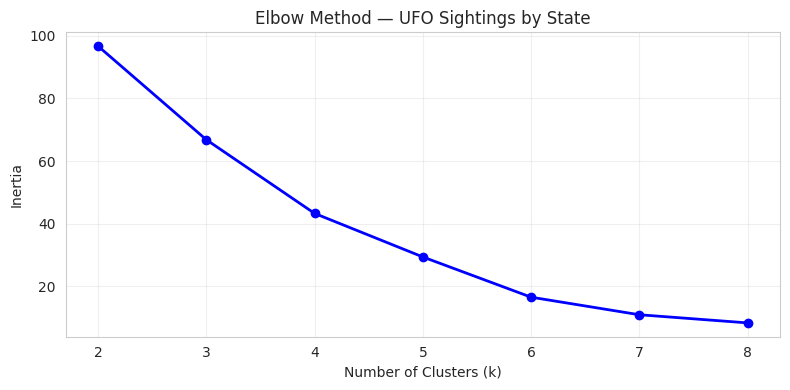

In [8]:
# Standardize and run Elbow Method
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(state_rfm[["Recency", "Frequency", "Magnitude"]])

inertias = []
K_range = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, "bo-", linewidth=2)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method — UFO Sightings by State")
plt.xticks(list(K_range))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# Fit K-Means with k=5
km = KMeans(n_clusters=5, random_state=42, n_init=10)
state_rfm["Cluster"] = km.fit_predict(rfm_scaled)

# Profile clusters
profiles = state_rfm.groupby("Cluster").agg(
    count=("state", "count"),
    avg_recency=("Recency", "mean"),
    avg_frequency=("Frequency", "mean"),
    avg_magnitude=("Magnitude", "mean")
).round(1)

print("Cluster Profiles:")
print(profiles.to_string())

Cluster Profiles:
         count  avg_recency  avg_frequency  avg_magnitude
Cluster                                                  
0           33         34.9          587.8          161.7
1            1       3598.0            7.0           30.0
2           10          3.2         2141.0          174.0
3            7         19.4          633.4          265.7
4            1          0.0         7239.0          180.0


In [10]:
# Identify the outlier cluster
outlier_cluster = profiles["avg_magnitude"].idxmax()
outlier_states = state_rfm[state_rfm["Cluster"] == outlier_cluster]

print(f"\n🔍 Outlier Cluster ({outlier_cluster}):")
print(f"   States: {list(outlier_states['state'].values)}")
print(f"   Avg duration: {profiles.loc[outlier_cluster, 'avg_magnitude']:,.0f} seconds")
print(f"   That's {profiles.loc[outlier_cluster, 'avg_magnitude'] / 86400:.1f} days")
print(f"\n   Are these real 100+ day UFO sightings? Almost certainly not.")
print(f"   This is what data quality issues look like in clustering output.")


🔍 Outlier Cluster (3):
   States: ['ak', 'az', 'de', 'ky', 'me', 'mt', 'nm']
   Avg duration: 266 seconds
   That's 0.0 days

   Are these real 100+ day UFO sightings? Almost certainly not.
   This is what data quality issues look like in clustering output.


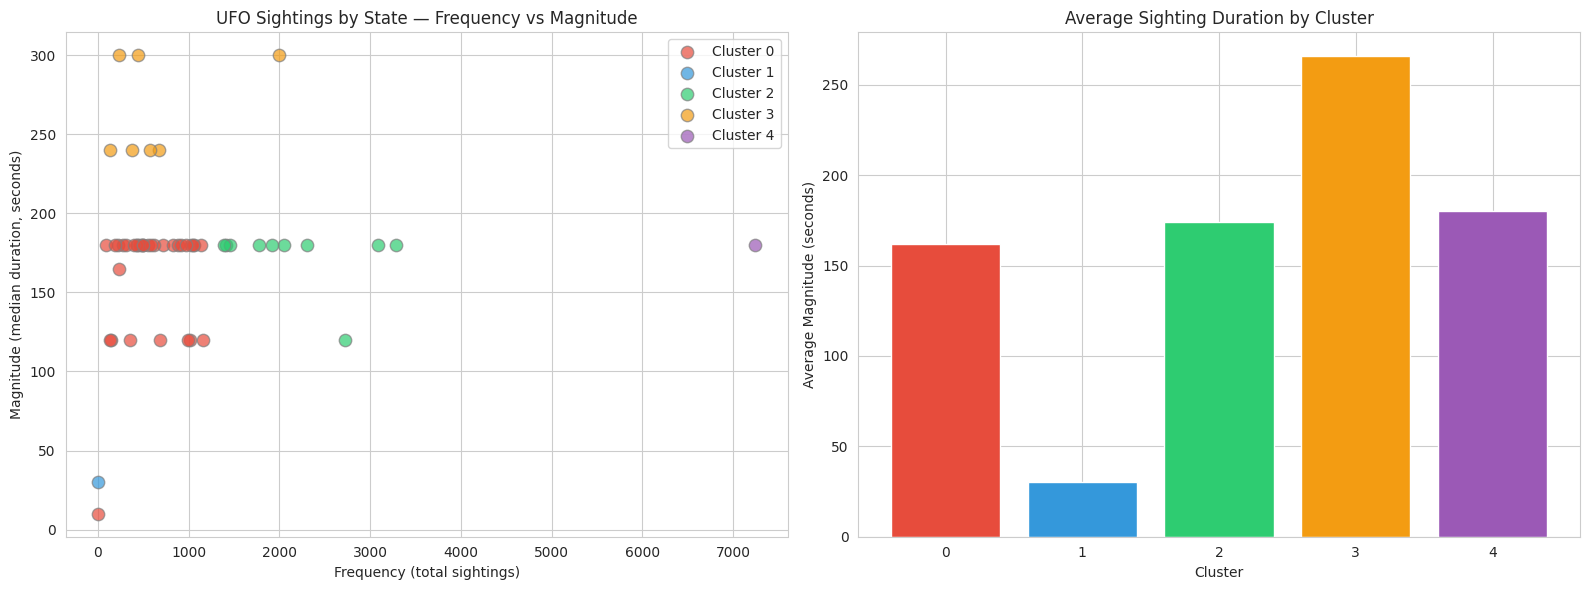

In [11]:
# Visualize: scatter + bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Frequency vs Magnitude by cluster
colors = ["#E74C3C", "#3498DB", "#2ECC71", "#F39C12", "#9B59B6"]
for c in sorted(state_rfm["Cluster"].unique()):
    mask = state_rfm["Cluster"] == c
    axes[0].scatter(state_rfm.loc[mask, "Frequency"],
                    state_rfm.loc[mask, "Magnitude"],
                    c=colors[c % len(colors)], label=f"Cluster {c}",
                    s=80, alpha=0.7, edgecolors="gray")
axes[0].set_xlabel("Frequency (total sightings)")
axes[0].set_ylabel("Magnitude (median duration, seconds)")
axes[0].set_title("UFO Sightings by State — Frequency vs Magnitude")
axes[0].legend()

# Panel 2: Average magnitude by cluster
axes[1].bar(profiles.index.astype(str), profiles["avg_magnitude"], color=colors[:len(profiles)])
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Average Magnitude (seconds)")
axes[1].set_title("Average Sighting Duration by Cluster")

plt.tight_layout()
plt.show()

<div style="background-color: #D6EAF8; border-left: 5px solid #2E86C1; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #1A5276;">💡 WHAT THE ALGORITHM FOUND</strong><br>
  One cluster has extreme average durations while all others are under 300 seconds. K-Means isolated the outliers automatically — that's the same pattern as the "Drifting Big Spenders" from Week 5. The algorithm finds what doesn't belong. Whether it's a data quality issue or a genuine extreme case is a <em>human</em> investigation, not a modeling problem.
</div>

### Your Turn #2

<div style="background-color: #D5F5E3; border-left: 5px solid #27AE60; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #1E8449;">✅ TRY THIS</strong><br>
  Remove the outlier cluster from <code>state_rfm</code> and re-run K-Means with k=4. How do the remaining clusters change? Does a new outlier emerge, or are the remaining states well-separated?
</div>

In [12]:
# Your Turn #2 — Remove outlier cluster and re-run
# Filter out the outlier cluster
state_rfm_clean = state_rfm[state_rfm["Cluster"] != outlier_cluster].copy()
print(f"Removed {len(state_rfm) - len(state_rfm_clean)} outlier states")
print(f"Remaining: {len(state_rfm_clean)} states")

# Re-standardize on clean data
scaler_clean = StandardScaler()
rfm_scaled_clean = scaler_clean.fit_transform(state_rfm_clean[["Recency", "Frequency", "Magnitude"]])

# Re-run K-Means with k=4 (one fewer cluster since outlier is gone)
km_clean = KMeans(n_clusters=4, random_state=42, n_init=10)
state_rfm_clean["Cluster"] = km_clean.fit_predict(rfm_scaled_clean)

profiles_clean = state_rfm_clean.groupby("Cluster").agg(
    count=("state", "count"),
    avg_recency=("Recency", "mean"),
    avg_frequency=("Frequency", "mean"),
    avg_magnitude=("Magnitude", "mean")
).round(1)

print(f"\nCluster Profiles (outlier removed):")
print(profiles_clean.to_string())

print(f"\nMax avg_magnitude is now {profiles_clean['avg_magnitude'].max():.0f}s ")
print(f"vs {profiles.loc[outlier_cluster, 'avg_magnitude']:,.0f}s before — ")
print(f"much more reasonable. Remaining clusters now separate states by Frequency + Recency patterns.")

Removed 7 outlier states
Remaining: 45 states

Cluster Profiles (outlier removed):
         count  avg_recency  avg_frequency  avg_magnitude
Cluster                                                  
0            9         87.2          802.4          107.8
1           34         11.7          987.8          179.6
2            1          0.0         7239.0          180.0
3            1       3598.0            7.0           30.0

Max avg_magnitude is now 180s 
vs 266s before — 
much more reasonable. Remaining clusters now separate states by Frequency + Recency patterns.


---
# Example 3 / Full Pipeline — The Universal Domain Template

<div style="background-color: #D6EAF8; border-left: 5px solid #2E86C1; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #1A5276;">💡 THE PORTABILITY PROOF</strong><br>
  This template has two sections: a <strong>configuration block</strong> (5 lines you modify) and a <strong>pipeline block</strong> (runs unchanged on any dataset). If you can fill in 5 variables, you can run a complete RFM + K-Means analysis on any domain.
</div>

### Configuration Section

In [13]:
# ============================================================
# ← MODIFY THIS SECTION — 5 configuration lines
# ============================================================
DATASET_URL = None  # Set to URL string, or None to use LMS fallback
ENTITY_COL = "student_id"
RECENCY_COL = "Recency"
FREQUENCY_COL = "Frequency"
MAGNITUDE_COL = "Magnitude"
RECENCY_REVERSED = True   # True = lower is better (most domains)
DOMAIN_NAME = "LMS Student Engagement"
CHOSEN_K = 3

# ============================================================
# ← DO NOT MODIFY BELOW THIS LINE
# ============================================================

### Pipeline Section (runs unchanged)

In [14]:
# Step 1: Load data
if DATASET_URL:
    template_df = pd.read_csv(DATASET_URL)
else:
    # Fallback: LMS data from Example 1
    template_df = lms_data[[ENTITY_COL, RECENCY_COL, FREQUENCY_COL, MAGNITUDE_COL]].copy()

print(f"Domain: {DOMAIN_NAME}")
print(f"Shape: {template_df.shape}")
print(f"\nRFM Ranges:")
for col in [RECENCY_COL, FREQUENCY_COL, MAGNITUDE_COL]:
    print(f"  {col}: {template_df[col].min():.1f} – {template_df[col].max():.1f} (mean: {template_df[col].mean():.1f})")

Domain: LMS Student Engagement
Shape: (10, 4)

RFM Ranges:
  Recency: 0.0 – 76.0 (mean: 22.5)
  Frequency: 5.0 – 60.0 (mean: 28.8)
  Magnitude: 1.0 – 10.0 (mean: 5.8)


In [15]:
# Step 2: Correlation check
rfm_cols_template = [RECENCY_COL, FREQUENCY_COL, MAGNITUDE_COL]
corr = template_df[rfm_cols_template].corr()
print("Correlation Matrix:")
print(corr.round(3).to_string())

# Flag high correlations
for i, c1 in enumerate(rfm_cols_template):
    for c2 in rfm_cols_template[i+1:]:
        r = abs(corr.loc[c1, c2])
        if r > 0.85:
            print(f"\n⚠️ WARNING: {c1} and {c2} correlation = {r:.3f}")
            print(f"   Clustering may be dominated by this pair. Consider swapping one metric.")

Correlation Matrix:
           Recency  Frequency  Magnitude
Recency      1.000     -0.842     -0.872
Frequency   -0.842      1.000      0.984
Magnitude   -0.872      0.984      1.000

⚠️ WARNING: Recency and Magnitude correlation = 0.872
   Clustering may be dominated by this pair. Consider swapping one metric.

⚠️ WARNING: Frequency and Magnitude correlation = 0.984
   Clustering may be dominated by this pair. Consider swapping one metric.


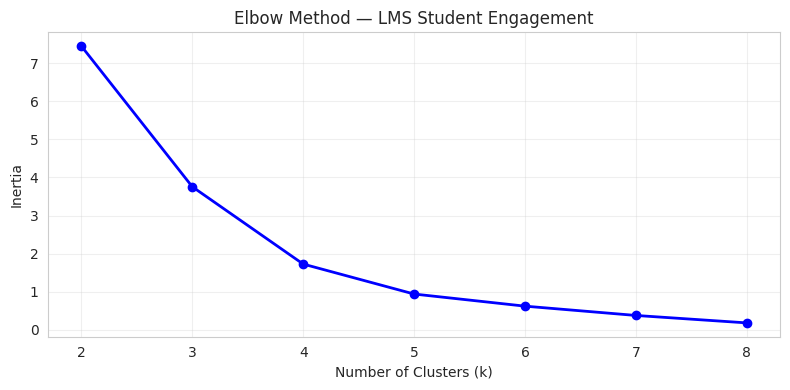

In [16]:
# Step 3: Standardize + Elbow Method
scaler_t = StandardScaler()
scaled_t = scaler_t.fit_transform(template_df[rfm_cols_template])

inertias_t = []
K_range_t = range(2, 9)
for k in K_range_t:
    km_t = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_t.fit(scaled_t)
    inertias_t.append(km_t.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range_t, inertias_t, "bo-", linewidth=2)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title(f"Elbow Method — {DOMAIN_NAME}")
plt.xticks(list(K_range_t))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Step 4: Fit K-Means + Profile
km_t = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10)
template_df["Cluster"] = km_t.fit_predict(scaled_t)

profiles_t = template_df.groupby("Cluster").agg(
    count=(ENTITY_COL, "count"),
    avg_R=(RECENCY_COL, "mean"),
    avg_F=(FREQUENCY_COL, "mean"),
    avg_M=(MAGNITUDE_COL, "mean")
).round(2)

print(f"Cluster Profiles — {DOMAIN_NAME}:")
print(profiles_t.to_string())

Cluster Profiles — LMS Student Engagement:
         count  avg_R  avg_F  avg_M
Cluster                            
0            4   1.50  48.25   9.25
1            3  60.33   9.33   2.33
2            3  12.67  22.33   4.67


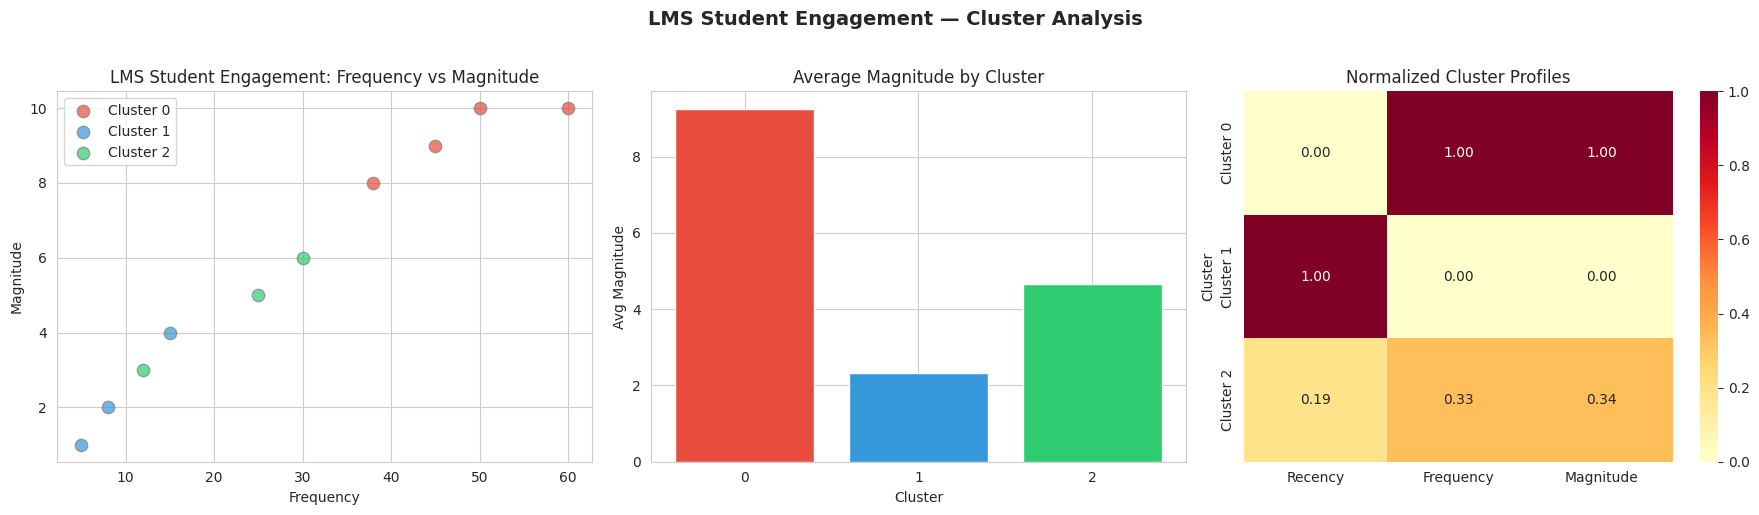

In [18]:
# Step 5: 3-Panel Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ["#E74C3C", "#3498DB", "#2ECC71", "#F39C12", "#9B59B6", "#1ABC9C"]

# Panel 1: Scatter — Frequency vs Magnitude
for c in sorted(template_df["Cluster"].unique()):
    mask = template_df["Cluster"] == c
    axes[0].scatter(template_df.loc[mask, FREQUENCY_COL],
                    template_df.loc[mask, MAGNITUDE_COL],
                    c=colors[c % len(colors)], label=f"Cluster {c}",
                    s=80, alpha=0.7, edgecolors="gray")
axes[0].set_xlabel(FREQUENCY_COL)
axes[0].set_ylabel(MAGNITUDE_COL)
axes[0].set_title(f"{DOMAIN_NAME}: Frequency vs Magnitude")
axes[0].legend()

# Panel 2: Bar chart — avg Magnitude by cluster
axes[1].bar(profiles_t.index.astype(str), profiles_t["avg_M"],
            color=colors[:len(profiles_t)])
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel(f"Avg {MAGNITUDE_COL}")
axes[1].set_title(f"Average Magnitude by Cluster")

# Panel 3: Heatmap — normalized cluster profiles
profile_norm = profiles_t[["avg_R", "avg_F", "avg_M"]].copy()
profile_norm = (profile_norm - profile_norm.min()) / (profile_norm.max() - profile_norm.min())
sns.heatmap(profile_norm, annot=True, fmt=".2f", cmap="YlOrRd",
            xticklabels=[RECENCY_COL, FREQUENCY_COL, MAGNITUDE_COL],
            yticklabels=[f"Cluster {i}" for i in profiles_t.index], ax=axes[2])
axes[2].set_title("Normalized Cluster Profiles")

plt.suptitle(f"{DOMAIN_NAME} — Cluster Analysis", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

In [19]:
# Step 6: Outlier detection
for c in profiles_t.index:
    ratio = profiles_t.loc[c, "avg_M"] / profiles_t["avg_M"].median()
    if ratio > 5:
        print(f"⚠️ Cluster {c} avg Magnitude is {ratio:.1f}x the median — possible outlier cluster")
    elif ratio < 0.2:
        print(f"⚠️ Cluster {c} avg Magnitude is {ratio:.1f}x the median — extremely low")

print(f"\n{'='*50}")
print(f"  {DOMAIN_NAME} — Analysis Complete")
print(f"  {len(template_df)} entities → {CHOSEN_K} clusters")
print(f"{'='*50}")


  LMS Student Engagement — Analysis Complete
  10 entities → 3 clusters


### Your Turn #3

<div style="background-color: #D5F5E3; border-left: 5px solid #27AE60; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #1E8449;">✅ TRY THIS</strong><br>
  Change the 5 configuration variables to run the template on the UFO state data (use the <code>state_rfm</code> DataFrame from Example 2). Set <code>DATASET_URL = None</code> and modify the fallback to use <code>state_rfm</code> instead of <code>lms_data</code>.
</div>

In [20]:
# Your Turn #3 — Swap the template to UFO data

# Override config for UFO domain
DATASET_URL = None
ENTITY_COL = "state"
RECENCY_COL = "Recency"
FREQUENCY_COL = "Frequency"
MAGNITUDE_COL = "Magnitude"
RECENCY_REVERSED = True
DOMAIN_NAME = "UFO Sightings by State"
CHOSEN_K = 5

# Use state_rfm from Example 2 as the data source
template_df = state_rfm[[ENTITY_COL, RECENCY_COL, FREQUENCY_COL, MAGNITUDE_COL]].copy()

print(f"Domain: {DOMAIN_NAME}")
print(f"Shape: {template_df.shape}")
print(f"\nRFM Ranges:")
for col in [RECENCY_COL, FREQUENCY_COL, MAGNITUDE_COL]:
    print(f"  {col}: {template_df[col].min():.1f} – {template_df[col].max():.1f} (mean: {template_df[col].mean():.1f})")

# Now re-run the pipeline cells above (Steps 2–6) without modifying them
# They will pick up the new DOMAIN_NAME, CHOSEN_K, and template_df automatically
print(f"\n✅ Config updated — re-run pipeline cells (Steps 2–6) above to see UFO results")

Domain: UFO Sightings by State
Shape: (52, 4)

RFM Ranges:
  Recency: 0.0 – 3598.0 (mean: 94.6)
  Frequency: 7.0 – 7239.0 (mean: 1009.4)
  Magnitude: 10.0 – 300.0 (mean: 175.9)

✅ Config updated — re-run pipeline cells (Steps 2–6) above to see UFO results


---
## Takeaway

<div style="background-color: #D5F5E3; border-left: 5px solid #27AE60; padding: 15px; margin: 15px 0; border-radius: 4px;">
  <strong style="color: #1E8449;">✅ WHAT WE PROVED TODAY</strong><br>
  The RFM + K-Means pipeline is a <strong>universal pattern-discovery framework</strong>. It works on any domain where you can define three behavioral dimensions for an entity. The code doesn't change — only the column names and interpretation.
</div>

**Universal Framework Checklist:**

| Question | You Need |
|----------|----------|
| What is your entity? | One row per entity (customer, student, city, member) |
| What is Recency? | A time-based measure — when was the last event? |
| What is Frequency? | A count — how often does the entity do the thing? |
| What is Magnitude? | A value measure — how much / how intense? |
| Is Recency reversed? | Usually yes — lower = more recent = better |

**Course progression — same data, three lenses:**

| Week | Question | Method |
|------|----------|--------|
| 5 | Who are our customers? | RFM + K-Means (retail) |
| 6 | What do they buy together? | Market Basket Analysis |
| 7 | Does this work everywhere? | RFM + K-Means (universal) |
| 8 | Final project | Your domain, your pipeline |

---
<p style="color:#7F8C8D; font-size:0.85em;">
<em>CAP4767 Data Mining with Python | Miami Dade College | Spring 2026</em><br>
Week 7 Demo — RFM Across Domains
</p>